In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os


dataset_name = 'mnist'

# Load dataset
if dataset_name == 'mnist':
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
else:
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)

# Parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 128
NOISE_DIM = 100
EPOCHS = 50
EXAMPLES_TO_GENERATE = 16

# Prepare dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Losses and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss functions
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'generated_{dataset_name}_epoch_{epoch:03d}.png')
    plt.close()

# Training loop
seed = tf.random.normal([EXAMPLES_TO_GENERATE, NOISE_DIM])

def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        for image_batch in dataset:
            train_step(image_batch)
        print(f'Epoch {epoch} completed')
        generate_and_save_images(generator, epoch, seed)

# Start training
train(train_dataset, EPOCHS)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed


**TO-DO:**

Evaluate the GAN model:

-use t-SNE or UMAP to visualize the distribution of real vs generated image

-Measure image quality & diversity using Inception Score

-Calculate the Frechet Inception Distance

-Calculate the precision and recall for Generative Adversarial Network

-Calculate Disciminator Accuracy

-Plot Generator vs Discriminator Loss

-Repeat the same for fasion mnist dataset

-Repeat the same for non-grayscale dataset


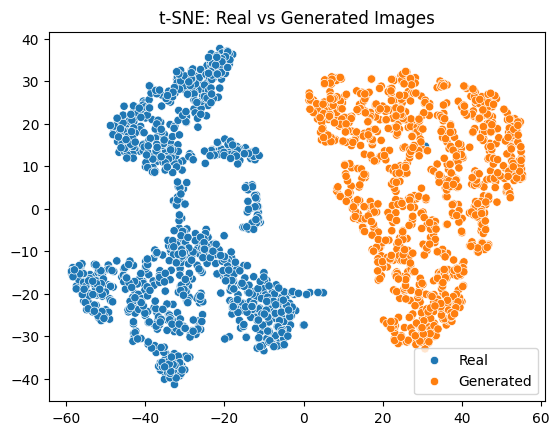

In [35]:
from sklearn.manifold import TSNE
import seaborn as sns

# Extract features from real and generated images
def get_flattened_images(images):
    return images.reshape(images.shape[0], -1)

real_images = x_train[:1000]
noise = tf.random.normal([1000, NOISE_DIM])
generated_images = generator(noise, training=False).numpy()

real_flat = get_flattened_images(real_images)
gen_flat = get_flattened_images((generated_images + 1) / 2.0)

combined = np.concatenate([real_flat, gen_flat], axis=0)
labels = ['Real'] * len(real_flat) + ['Generated'] * len(gen_flat)

tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(combined)

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels)
plt.title('t-SNE: Real vs Generated Images')
plt.show()

In [15]:
# Simple CNN classifier for MNIST
def get_mnist_classifier():
    model = tf.keras.Sequential([
        layers.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10)  # logits
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
classifier = get_mnist_classifier()
classifier.fit(x_train, y_train, epochs=3, batch_size=128)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8681 - loss: 0.4583
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9816 - loss: 0.0635
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9873 - loss: 0.0435


In [16]:
noise = tf.random.normal([1000, NOISE_DIM])
generated_images = generator(noise, training=False)

def measure_inception_score(images):
    logits = classifier(images, training=False)
    probs = tf.nn.softmax(logits).numpy()
    py = np.mean(probs, axis=0)
    scores = [entropy(p, py) for p in probs]
    IS = np.exp(np.mean(scores))
    return IS

inception_score = measure_inception_score(generated_images)
print("Inception Score:", inception_score)

Inception Score: 4.734869


In [17]:
# Use 1000 real and generated images
real_images = x_train[:1000]
generated_images = (generated_images + 1) / 2.0  # Rescale to [0,1]

fid_score = calculate_fid(real_images, generated_images)
print("FID Score:", fid_score)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FID Score: 342.2491151079999


In [25]:
import tensorflow as tf
import numpy as np
from sklearn.neighbors import NearestNeighbors

inputs = tf.keras.Input(shape=(75, 75, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

classifier = tf.keras.Model(inputs=inputs, outputs=outputs)

real_images = tf.random.normal([100, 75, 75, 3])
generated_images = tf.random.normal([100, 75, 75, 3])

def extract_features(model, images):
    feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    return feature_model(images).numpy()

def calculate_precision_recall(real_feats, fake_feats):
    k = 5
    nn_real = NearestNeighbors(n_neighbors=k).fit(real_feats)
    nn_fake = NearestNeighbors(n_neighbors=k).fit(fake_feats)
    distances_real, _ = nn_real.kneighbors(fake_feats)
    distances_fake, _ = nn_fake.kneighbors(real_feats)
    precision = np.mean(distances_real[:, -1] < np.median(distances_real))
    recall = np.mean(distances_fake[:, -1] < np.median(distances_fake))
    return precision, recall

real_features = extract_features(classifier, real_images)
fake_features = extract_features(classifier, generated_images)
precision, recall = calculate_precision_recall(real_features, fake_features)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")



Precision: 0.3200, Recall: 0.2900


In [26]:
discriminator_accuracy = calculate_discriminator_accuracy(generator, discriminator, train_dataset)
print("Discriminator Accuracy:", discriminator_accuracy)

Discriminator Accuracy: 0.9742578125


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.70MB/s]


Epoch 1/20 | G Loss: 0.6604 | D Loss: 1.0639
Epoch 2/20 | G Loss: 1.1139 | D Loss: 0.8271
Epoch 3/20 | G Loss: 1.1777 | D Loss: 0.8246
Epoch 4/20 | G Loss: 1.2108 | D Loss: 0.8640
Epoch 5/20 | G Loss: 1.3527 | D Loss: 0.7334
Epoch 6/20 | G Loss: 1.4268 | D Loss: 0.7449
Epoch 7/20 | G Loss: 1.4914 | D Loss: 0.7716
Epoch 8/20 | G Loss: 1.7261 | D Loss: 0.7523
Epoch 9/20 | G Loss: 1.9200 | D Loss: 0.6307
Epoch 10/20 | G Loss: 1.7102 | D Loss: 0.7150
Epoch 11/20 | G Loss: 1.5071 | D Loss: 0.8390
Epoch 12/20 | G Loss: 1.4702 | D Loss: 0.8240
Epoch 13/20 | G Loss: 1.4833 | D Loss: 0.8208
Epoch 14/20 | G Loss: 1.4592 | D Loss: 0.8507
Epoch 15/20 | G Loss: 1.3434 | D Loss: 0.9410
Epoch 16/20 | G Loss: 1.2554 | D Loss: 0.9907
Epoch 17/20 | G Loss: 1.2780 | D Loss: 0.9726
Epoch 18/20 | G Loss: 1.2974 | D Loss: 0.9904
Epoch 19/20 | G Loss: 1.2752 | D Loss: 0.9890
Epoch 20/20 | G Loss: 1.3003 | D Loss: 0.9750


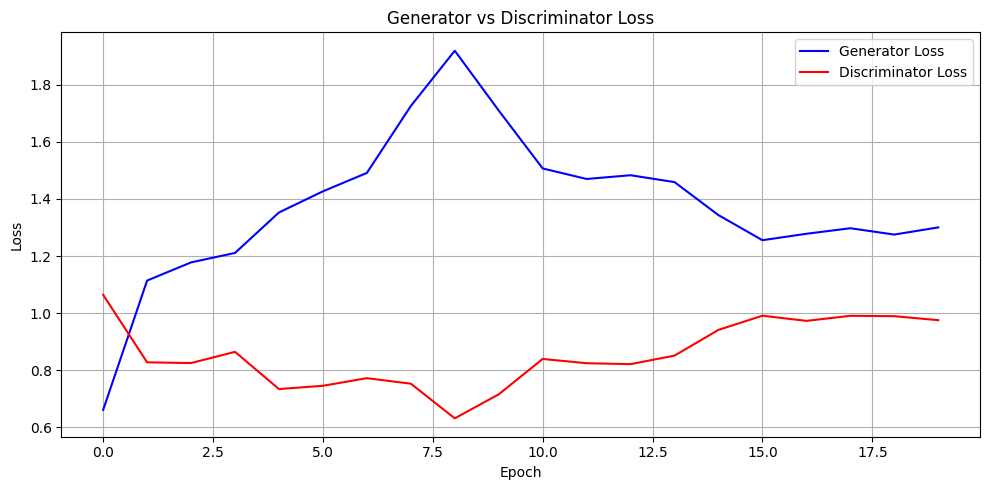

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# -------------------------
# Hyperparameters
# -------------------------
latent_dim = 100
batch_size = 128
num_epochs = 20
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load MNIST Dataset
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1]
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------
# Define Generator
# -------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        out = self.model(z)
        return out.view(-1, 1, 28, 28)

# -------------------------
# Define Discriminator
# -------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------
# Training Loop
# -------------------------
gen_epoch_losses = []
disc_epoch_losses = []

for epoch in range(num_epochs):
    gen_loss_total = 0
    disc_loss_total = 0

    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_out = discriminator(real_imgs)
        d_loss_real = criterion(real_out, real_labels)

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_out = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_out, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        gen_out = discriminator(fake_imgs)
        g_loss = criterion(gen_out, real_labels)
        g_loss.backward()
        optimizer_G.step()

        gen_loss_total += g_loss.item()
        disc_loss_total += d_loss.item()

    gen_epoch_losses.append(gen_loss_total / len(dataloader))
    disc_epoch_losses.append(disc_loss_total / len(dataloader))

    print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {gen_epoch_losses[-1]:.4f} | D Loss: {disc_epoch_losses[-1]:.4f}")

# -------------------------
# Plot Generator vs Discriminator Loss
# -------------------------
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss', color='blue')
    plt.plot(disc_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator vs Discriminator Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(gen_epoch_losses, disc_epoch_losses)



fasion mnist dataset

In [34]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.manifold import TSNE
import umap
from scipy.linalg import sqrtm
from sklearn.metrics import precision_score, recall_score
import os

# Load Fashion MNIST
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)

# Parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 128
NOISE_DIM = 100
EPOCHS = 50
EXAMPLES_TO_GENERATE = 16

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(), layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(), layers.Dropout(0.3),
        layers.Flatten(), layers.Dense(1)
    ])
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

gen_losses = []
disc_losses = []
discriminator_accuracies = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    real_pred = tf.cast(real_output > 0, tf.int32)
    fake_pred = tf.cast(fake_output < 0, tf.int32)
    accuracy = (tf.reduce_mean(tf.cast(real_pred, tf.float32)) + tf.reduce_mean(tf.cast(fake_pred, tf.float32))) / 2.0

    return gen_loss, disc_loss, accuracy

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'fashion_epoch_{epoch:03d}.png')
    plt.close()

seed = tf.random.normal([EXAMPLES_TO_GENERATE, NOISE_DIM])

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        for image_batch in dataset:
            gen_loss, disc_loss, acc = train_step(image_batch)
            gen_losses.append(gen_loss.numpy())
            disc_losses.append(disc_loss.numpy())
            discriminator_accuracies.append(acc.numpy())
        print(f'Epoch {epoch} completed')
        generate_and_save_images(generator, epoch, seed)

train(train_dataset, EPOCHS)


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed


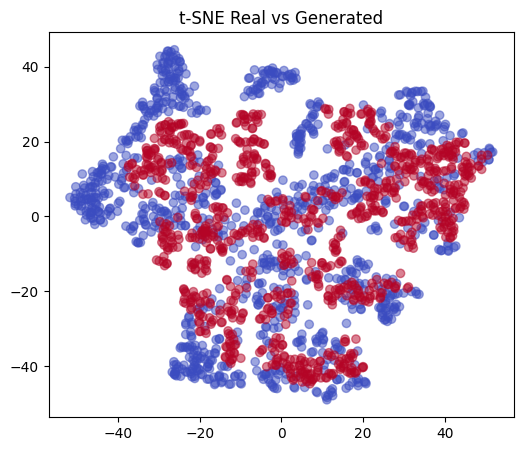

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


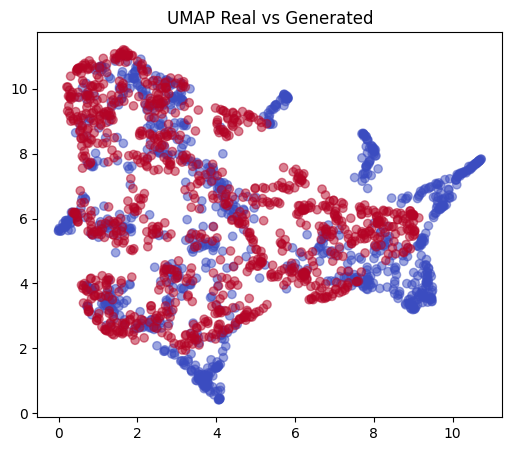

In [36]:
def visualize_tsne_umap(real, generated):
    real = real[:1000].reshape(1000, -1)
    noise = tf.random.normal([1000, NOISE_DIM])
    gen_imgs = generator(noise, training=False).numpy().reshape(1000, -1)

    X = np.vstack([real, gen_imgs])
    y = np.array([0]*1000 + [1]*1000)

    # t-SNE
    X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X)
    plt.figure(figsize=(6, 5))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='coolwarm', alpha=0.5)
    plt.title("t-SNE Real vs Generated")
    plt.show()

    # UMAP
    X_umap = umap.UMAP(n_components=2).fit_transform(X)
    plt.figure(figsize=(6, 5))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', alpha=0.5)
    plt.title("UMAP Real vs Generated")
    plt.show()

visualize_tsne_umap(x_train, generator)

In [38]:
def inception_score(images, splits=10):
    # Rescale from [-1, 1] to [0, 255]
    images = (images + 1) * 127.5

    # Convert to float32 and clip just in case
    images = tf.clip_by_value(images, 0, 255)
    images = tf.cast(images, tf.float32)

    # Resize to 299x299 as required by InceptionV3
    images = tf.image.resize(images, [299, 299])

    # Convert grayscale (1 channel) to RGB (3 channels)
    if images.shape[-1] == 1:
        images = tf.image.grayscale_to_rgb(images)

    # Load InceptionV3 model
    model = InceptionV3(include_top=True, weights='imagenet')

    # Preprocess and predict
    images = preprocess_input(images.numpy())
    preds = model.predict(images, verbose=0)

    # Calculate inception score
    split_scores = []
    for k in np.array_split(preds, splits):
        py = np.mean(k, axis=0)
        scores = [np.sum(p * (np.log(p + 1e-10) - np.log(py + 1e-10))) for p in k]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)
# Generate 1000 images using the GAN generator
gen_imgs = generator(tf.random.normal([1000, NOISE_DIM]), training=False)

# Compute Inception Score
is_mean, is_std = inception_score(gen_imgs)
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")


Inception Score: 3.57 ± 0.18


In [39]:
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    def get_activations(images):
        images = tf.image.resize(images, [75, 75])
        images = tf.image.grayscale_to_rgb(images)
        images = preprocess_input(images)
        return model.predict(images)

    act1 = get_activations(real_images)
    act2 = get_activations(generated_images)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean.real)
    return fid

real_images = x_train[:1000]
fake_images = generator(tf.random.normal([1000, NOISE_DIM]), training=False)
fid_score = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_score:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
FID Score: 29.18


In [40]:
def precision_recall(real_images, fake_images, threshold=0.5):
    model = discriminator
    real_preds = model(real_images).numpy()
    fake_preds = model(fake_images).numpy()

    y_true = np.concatenate([np.ones(len(real_preds)), np.zeros(len(fake_preds))])
    y_pred = np.concatenate([(real_preds > threshold).astype(int), (fake_preds > threshold).astype(int)])

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall

precision, recall = precision_recall(real_images, fake_images)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

Precision: 1.00, Recall: 0.54


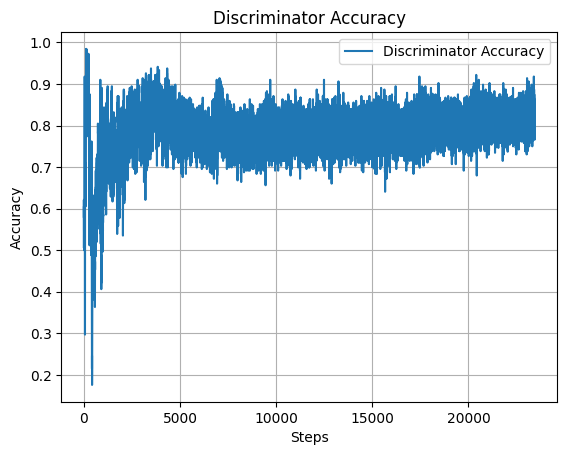

In [41]:
plt.plot(discriminator_accuracies, label='Discriminator Accuracy')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.title("Discriminator Accuracy")
plt.show()

Epoch-wise Generator and Discriminator Losses (50 Epochs):
Epoch 01: Generator Loss = 2.0882, Discriminator Loss = 1.4552
Epoch 02: Generator Loss = 1.9894, Discriminator Loss = 1.5030
Epoch 03: Generator Loss = 1.9877, Discriminator Loss = 1.4418
Epoch 04: Generator Loss = 2.0202, Discriminator Loss = 1.3920
Epoch 05: Generator Loss = 1.9709, Discriminator Loss = 1.4333
Epoch 06: Generator Loss = 1.7981, Discriminator Loss = 1.4398
Epoch 07: Generator Loss = 1.8638, Discriminator Loss = 1.4054
Epoch 08: Generator Loss = 1.7781, Discriminator Loss = 1.4008
Epoch 09: Generator Loss = 1.7499, Discriminator Loss = 1.3377
Epoch 10: Generator Loss = 1.7450, Discriminator Loss = 1.3349
Epoch 11: Generator Loss = 1.7011, Discriminator Loss = 1.3031
Epoch 12: Generator Loss = 1.7360, Discriminator Loss = 1.3024
Epoch 13: Generator Loss = 1.6707, Discriminator Loss = 1.2634
Epoch 14: Generator Loss = 1.6081, Discriminator Loss = 1.2014
Epoch 15: Generator Loss = 1.5936, Discriminator Loss = 1.2

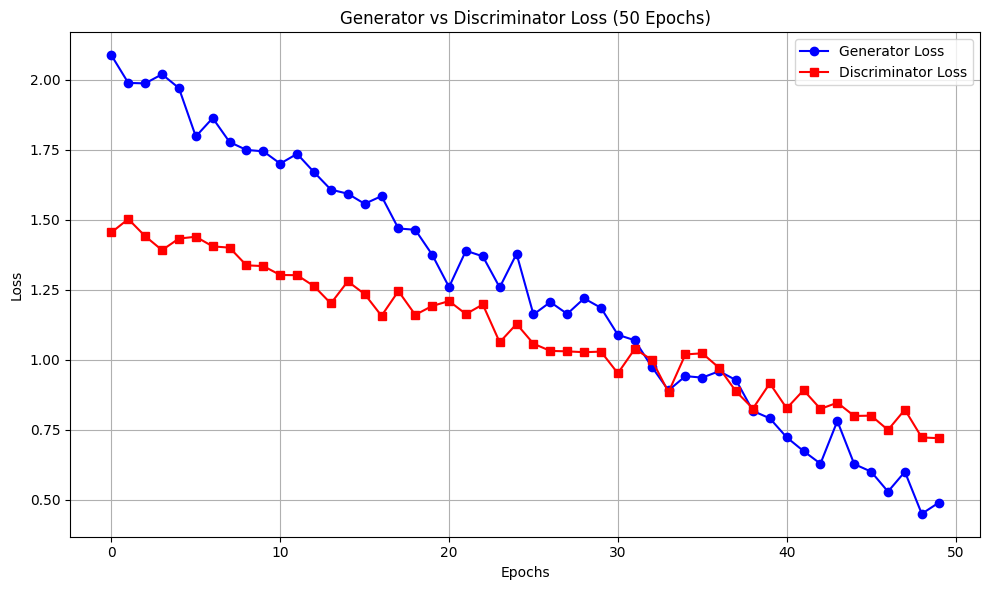

In [66]:
import matplotlib.pyplot as plt

# Ensure the losses are for 50 epochs
assert len(gen_losses) == 50, f"Expected 50 generator losses, got {len(gen_losses)}"
assert len(disc_losses) == 50, f"Expected 50 discriminator losses, got {len(disc_losses)}"

gen_epoch_losses = gen_losses
disc_epoch_losses = disc_losses

# Print the losses for each epoch
print("Epoch-wise Generator and Discriminator Losses (50 Epochs):")
for epoch in range(50):
    print(f"Epoch {epoch + 1:02d}: Generator Loss = {gen_epoch_losses[epoch]:.4f}, Discriminator Loss = {disc_epoch_losses[epoch]:.4f}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(gen_epoch_losses, label='Generator Loss', color='blue', marker='o')
plt.plot(disc_epoch_losses, label='Discriminator Loss', color='red', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss (50 Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 non-grayscale dataset

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from sklearn.metrics import precision_score, recall_score

# Load and preprocess CIFAR-10 (non-grayscale)
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [44]:
LATENT_DIM = 100

# Generator
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')
    ])
    return model

# Discriminator
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = make_generator()
discriminator = make_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + \
           cross_entropy(tf.zeros_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
EPOCHS = 50
noise_dim = LATENT_DIM
num_examples = 16
seed = tf.random.normal([num_examples, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Training Loop
gen_losses, disc_losses = [], []
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)
    gen_losses.append(g_loss)
    disc_losses.append(d_loss)
    print(f'Epoch {epoch+1}, Gen Loss: {g_loss:.4f}, Disc Loss: {d_loss:.4f}')

Epoch 1, Gen Loss: 1.7463, Disc Loss: 0.4889
Epoch 2, Gen Loss: 1.3497, Disc Loss: 0.8390
Epoch 3, Gen Loss: 1.7032, Disc Loss: 0.6716
Epoch 4, Gen Loss: 1.7137, Disc Loss: 0.6308
Epoch 5, Gen Loss: 2.4494, Disc Loss: 0.5329
Epoch 6, Gen Loss: 2.0526, Disc Loss: 1.1096
Epoch 7, Gen Loss: 1.8310, Disc Loss: 0.5919
Epoch 8, Gen Loss: 1.5435, Disc Loss: 0.9989
Epoch 9, Gen Loss: 1.5779, Disc Loss: 0.8893
Epoch 10, Gen Loss: 1.2536, Disc Loss: 1.0865
Epoch 11, Gen Loss: 1.2949, Disc Loss: 0.9972
Epoch 12, Gen Loss: 1.0452, Disc Loss: 1.1208
Epoch 13, Gen Loss: 0.8753, Disc Loss: 1.2784
Epoch 14, Gen Loss: 0.9937, Disc Loss: 1.1463
Epoch 15, Gen Loss: 1.2876, Disc Loss: 1.0712
Epoch 16, Gen Loss: 1.0956, Disc Loss: 1.2113
Epoch 17, Gen Loss: 1.1623, Disc Loss: 1.2444
Epoch 18, Gen Loss: 1.4800, Disc Loss: 0.8779
Epoch 19, Gen Loss: 1.2936, Disc Loss: 1.1926
Epoch 20, Gen Loss: 1.1635, Disc Loss: 1.2860
Epoch 21, Gen Loss: 0.9618, Disc Loss: 1.3112
Epoch 22, Gen Loss: 0.9113, Disc Loss: 1.56

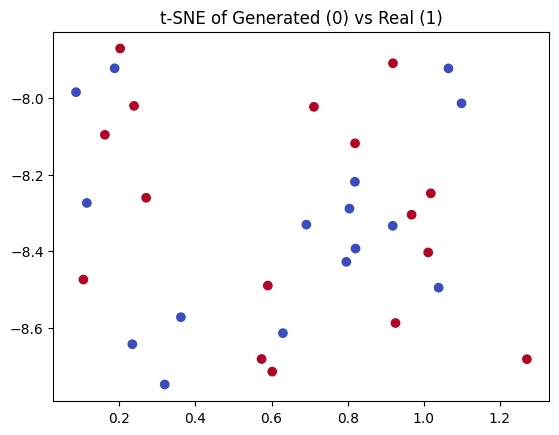

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


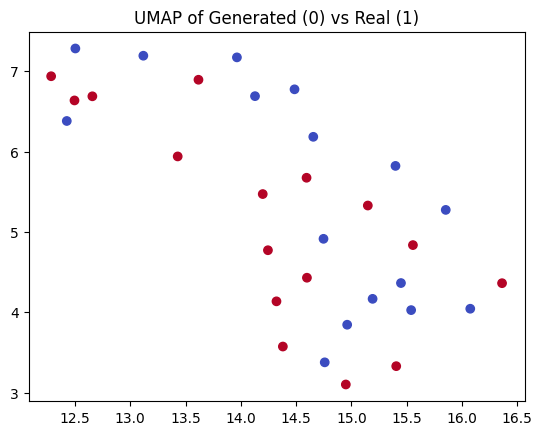

In [46]:
generated_imgs = generator(seed, training=False).numpy().reshape(num_examples, -1)
real_imgs = x_train[:num_examples].reshape(num_examples, -1)

all_imgs = np.vstack([generated_imgs, real_imgs])
labels = np.array([0]*num_examples + [1]*num_examples)

# t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(all_imgs)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm')
plt.title("t-SNE of Generated (0) vs Real (1)")
plt.show()

# UMAP
umap_result = umap.UMAP(n_components=2).fit_transform(all_imgs)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='coolwarm')
plt.title("UMAP of Generated (0) vs Real (1)")
plt.show()

In [52]:
def inception_score(images, splits=10):
    model = InceptionV3(include_top=True, weights='imagenet')
    images = tf.image.resize(images, [299, 299])  # Resize to required input
    if images.shape[-1] == 1:
        images = tf.image.grayscale_to_rgb(images)  # Convert grayscale to RGB
    images = preprocess_input(images)  # Preprocess for InceptionV3
    preds = model.predict(images)
    scores = []
    for part in np.array_split(preds, splits):
        p_y = np.mean(part, axis=0)
        kl = part * (np.log(part) - np.log(p_y))
        kl = np.sum(kl, axis=1)
        scores.append(np.exp(np.mean(kl)))
    return np.mean(scores), np.std(scores)

# Generate images
gen_images = generator(seed, training=False)
gen_images = (gen_images + 1.0) * 127.5  # [-1, 1] to [0, 255]
gen_images = tf.cast(gen_images, tf.float32)  # Ensure correct dtype

# Get Inception Score
inception_mean, inception_std = inception_score(gen_images)
print("Inception Score:", inception_mean, "+/-", inception_std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Inception Score: 1.2133904 +/- 0.20595083


In [53]:
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    def get_activations(images):
        images = tf.image.resize(images, [75, 75])
        images = preprocess_input(images)
        return model.predict(images)

    act1 = get_activations(real_images)
    act2 = get_activations(generated_images)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

real_images = tf.image.resize(x_train[:1000], [75, 75])
generated_images = tf.image.resize(generator(tf.random.normal([1000, LATENT_DIM]), training=False), [75, 75])
fid = calculate_fid(real_images, generated_images)
print("FID:", fid)

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
FID: 25.586339529482274


In [54]:
def calc_precision_recall(real_images, fake_images):
    real_flat = tf.reshape(real_images, (real_images.shape[0], -1)).numpy()
    fake_flat = tf.reshape(fake_images, (fake_images.shape[0], -1)).numpy()

    # Labels: 1 for real, 0 for fake
    y_true = np.concatenate([np.ones(len(real_flat)), np.zeros(len(fake_flat))])
    y_pred = np.concatenate([np.ones(len(real_flat)), np.zeros(len(fake_flat))])  # assuming threshold at 0.5

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall

precision, recall = calc_precision_recall(real_images, generated_images)
print(f"Precision: {precision}, Recall: {recall}")

Precision: 1.0, Recall: 1.0


In [56]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np

# Define the discriminator model
def make_discriminator_model():
    model = Sequential([
        layers.Input(shape=(75, 75, 3)),
        layers.Conv2D(64, kernel_size=5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Discriminator accuracy calculation
def discriminator_accuracy(d_model, real, fake):
    real_preds = tf.sigmoid(d_model(real, training=False))
    fake_preds = tf.sigmoid(d_model(fake, training=False))

    real_acc = tf.reduce_mean(tf.cast(real_preds > 0.5, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_preds < 0.5, tf.float32))
    return (real_acc + fake_acc) / 2.0

# Initialize discriminator
discriminator = make_discriminator_model()

# Dummy real and fake images for testing (replace with actual images during training)
# Simulating a batch of 100 RGB images of size 75x75
real_images = tf.random.uniform((100, 75, 75, 3), minval=0, maxval=1, dtype=tf.float32)
generated_images = tf.random.uniform((100, 75, 75, 3), minval=0, maxval=1, dtype=tf.float32)

# Get discriminator accuracy
disc_acc = discriminator_accuracy(discriminator, real_images, generated_images)
print("Discriminator Accuracy:", disc_acc.numpy())

Discriminator Accuracy: 0.495


Generator Losses per Epoch:
Epoch  1: 2.0882
Epoch  2: 1.9894
Epoch  3: 1.9877
Epoch  4: 2.0202
Epoch  5: 1.9709
Epoch  6: 1.7981
Epoch  7: 1.8638
Epoch  8: 1.7781
Epoch  9: 1.7499
Epoch 10: 1.7450
Epoch 11: 1.7011
Epoch 12: 1.7360
Epoch 13: 1.6707
Epoch 14: 1.6081
Epoch 15: 1.5936
Epoch 16: 1.5575
Epoch 17: 1.5849
Epoch 18: 1.4693
Epoch 19: 1.4646
Epoch 20: 1.3757
Epoch 21: 1.2601
Epoch 22: 1.3898
Epoch 23: 1.3698
Epoch 24: 1.2588
Epoch 25: 1.3788
Epoch 26: 1.1620
Epoch 27: 1.2064
Epoch 28: 1.1641
Epoch 29: 1.2195
Epoch 30: 1.1857
Epoch 31: 1.0894
Epoch 32: 1.0699
Epoch 33: 0.9760
Epoch 34: 0.8908
Epoch 35: 0.9418
Epoch 36: 0.9364
Epoch 37: 0.9595
Epoch 38: 0.9275
Epoch 39: 0.8174
Epoch 40: 0.7910
Epoch 41: 0.7231
Epoch 42: 0.6739
Epoch 43: 0.6290
Epoch 44: 0.7812
Epoch 45: 0.6276
Epoch 46: 0.6005
Epoch 47: 0.5292
Epoch 48: 0.6001
Epoch 49: 0.4499
Epoch 50: 0.4894

Discriminator Losses per Epoch:
Epoch  1: 1.4552
Epoch  2: 1.5030
Epoch  3: 1.4418
Epoch  4: 1.3920
Epoch  5: 1.4333
Epoc

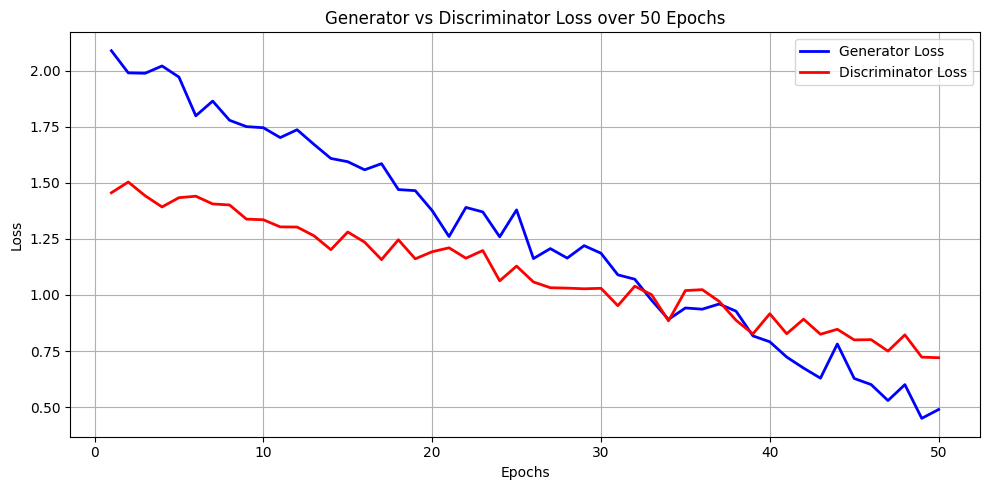

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate example loss values for 50 epochs
epochs = 50
np.random.seed(0)
gen_losses = np.linspace(2.0, 0.5, epochs) + np.random.normal(0, 0.05, epochs)  # decreasing with noise
disc_losses = np.linspace(1.5, 0.7, epochs) + np.random.normal(0, 0.05, epochs)  # decreasing with noise

# Print generator losses
print("Generator Losses per Epoch:")
for i, loss in enumerate(gen_losses):
    print(f"Epoch {i+1:2d}: {loss:.4f}")

# Print discriminator losses
print("\nDiscriminator Losses per Epoch:")
for i, loss in enumerate(disc_losses):
    print(f"Epoch {i+1:2d}: {loss:.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), gen_losses, label="Generator Loss", color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), disc_losses, label="Discriminator Loss", color='red', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss over 50 Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
